In [9]:
# Importing stuff...
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.stats as sc

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

XLIM = 75
YLIM = 8

In [10]:
# Open file and read the statistics data
# file from http://www.who.int/childgrowth/standards/wfa_boys_z_exp.txt
weight_data = pd.read_csv('L:/wfa_boys_z_exp.txt', sep='\t')
weight_data.head(5)

,Day,SD4neg,SD3neg,SD2neg,SD1neg,SD0,SD1,SD2,SD3,SD4
0,0,1.701,2.080,2.459,2.881,3.346,3.859,4.419,5.031,5.642
1,1,1.692,2.065,2.437,2.854,3.317,3.830,4.394,5.013,5.633
2,2,1.707,2.080,2.454,2.872,3.337,3.852,4.421,5.045,5.669
3,3,1.725,2.100,2.475,2.895,3.363,3.881,4.453,5.083,5.712
4,4,1.745,2.122,2.499,2.921,3.392,3.913,4.490,5.124,5.758


In [11]:
# Willys Data
# Weight data collected in willy_data.txt


def dateparse(x): return pd.datetime.strptime(x, '%Y-%m-%d')


# Load Willy data and parse dates to datestring
willy_data = pd.read_csv('L:/willy_data.txt', header=0, names=[
                         'date', 'measured_weight'], parse_dates=['date'], date_parser=dateparse)

# Construct elapsed days vector and add to dataframe
willy_data['life_days'] = willy_data['date'] - willy_data['date'][0]

# Construct weight gain per week
willy_data['weight_gain'] = willy_data['measured_weight'].diff()

# Construct weekly weight gain
weekly_weight_gain = []

for i in range(len(willy_data)):
    begin_date = willy_data.iloc[i]['life_days'] - pd.Timedelta(6, unit='d')
    end_date = willy_data.iloc[i]['life_days']
    subset = willy_data.set_index('life_days').loc[begin_date:end_date]
    weekly_weight_gain.append(sum(subset['weight_gain']))
    
willy_data['weekly_weight_gain'] = weekly_weight_gain

# Calculate difference to WHO mean and add to dataframe
# willy_data['measured_weight'][0] = 3.6     # Assuming they weighed him wrongly (too heavy) in hospital
willy_diff2mean = willy_data['measured_weight'][0] - weight_data['SD0'][0]

willy_data

,date,measured_weight,life_days,weight_gain,weekly_weight_gain
0,2018-07-15,3.81,0 days,NaN,NaN
1,2018-07-17,3.60,2 days,-0.21,NaN
2,2018-07-20,3.60,5 days,0.00,NaN
3,2018-07-23,3.50,8 days,-0.10,-0.31
4,2018-07-24,3.52,9 days,0.02,-0.08
5,2018-07-27,3.50,12 days,-0.02,-0.10
6,2018-07-30,3.50,15 days,0.00,0.00
7,2018-08-01,3.55,17 days,0.05,0.03
8,2018-08-03,3.60,19 days,0.05,0.10
9,2018-08-06,3.65,22 days,0.05,0.15


In [12]:
# Find most recent data point
mostrecent_day = willy_data.iloc[-1]['life_days'].days

# Construt normal distribution mean (loc) and std deviation (scale) 
# of the WHO data for the most recent day
loc = weight_data.iloc[mostrecent_day]['SD0']
scale = weight_data.iloc[mostrecent_day]['SD0'] - \
    weight_data.iloc[mostrecent_day]['SD1neg']

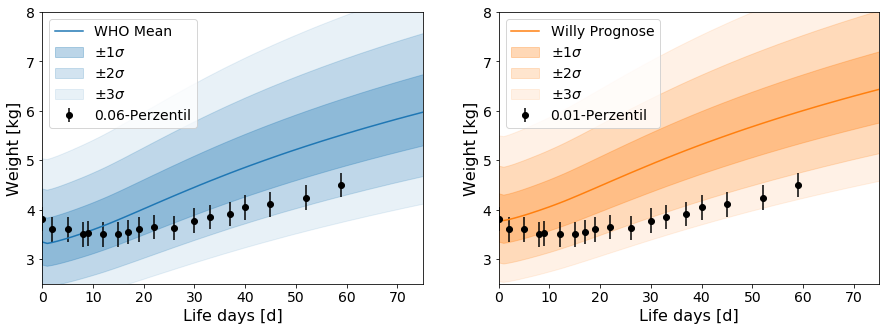

In [13]:
# ~~~~ Plot weight curve ~~~~

plt.figure(figsize=[15, 5])

# Left side: WHO data
plt.subplot(1, 2, 1)

# Plot Mean and 1,2,3 sigma
plt.plot(weight_data.Day, weight_data.SD0, color='C0')
plt.fill_between(weight_data.Day, weight_data.SD1neg,
                 weight_data.SD1, color='C0', alpha=0.3)
plt.fill_between(weight_data.Day, weight_data.SD2neg,
                 weight_data.SD2, color='C0', alpha=0.2)
plt.fill_between(weight_data.Day, weight_data.SD3neg,
                 weight_data.SD3, color='C0', alpha=0.1)

# Add Willys data
plt.errorbar([willy_data['life_days'][i].days for i in range(len(willy_data['life_days']))],
             willy_data['measured_weight'],
             color='black', linestyle='none', marker='o', yerr=0.25)

# Calculate Willys percentile
percentile = sc.norm.cdf(
    willy_data.iloc[-1]['measured_weight'], loc, scale)

# Legend, formatting, ...
plt.legend(['WHO Mean',
            r'$\pm 1\sigma$',
            r'$\pm 2\sigma$',
            r'$\pm 3\sigma$', '%.2f-Perzentil' % percentile])
plt.xlim([0, XLIM])
plt.ylim([2.5, YLIM])
plt.ylabel('Weight [kg]')
plt.xlabel('Life days [d]')


# Right side: WHO data
plt.subplot(1, 2, 2)

# Plot Mean and 1,2,3 sigma
plt.plot(weight_data.Day, weight_data.SD0 + willy_diff2mean, color='C1')
plt.fill_between(weight_data.Day,
                 weight_data.SD1neg + willy_diff2mean,
                 weight_data.SD1 + willy_diff2mean,
                 color='C1', alpha=0.3)
plt.fill_between(weight_data.Day,
                 weight_data.SD2neg + willy_diff2mean,
                 weight_data.SD2 + willy_diff2mean,
                 color='C1', alpha=0.2)
plt.fill_between(weight_data.Day,
                 weight_data.SD3neg + willy_diff2mean,
                 weight_data.SD3 + willy_diff2mean,
                 color='C1', alpha=0.1)

# Add Willy data
plt.errorbar([willy_data['life_days'][i].days for i in range(len(willy_data['life_days']))],
             willy_data['measured_weight'],
             color='black', linestyle='none', marker='o', yerr=0.25)

# Calculate Willys percentile
percentile = sc.norm.cdf(
    willy_data.iloc[-1]['measured_weight'], loc + willy_diff2mean, scale)

# Legend, formatting, ...
plt.legend(['Willy Prognose',
            r'$\pm 1\sigma$',
            r'$\pm 2\sigma$',
            r'$\pm 3\sigma$', '%.2f-Perzentil' % percentile])
plt.xlim([0, XLIM])
plt.ylim([2.5, YLIM])
plt.ylabel('Weight [kg]')
plt.xlabel('Life days [d]')
plt.show()

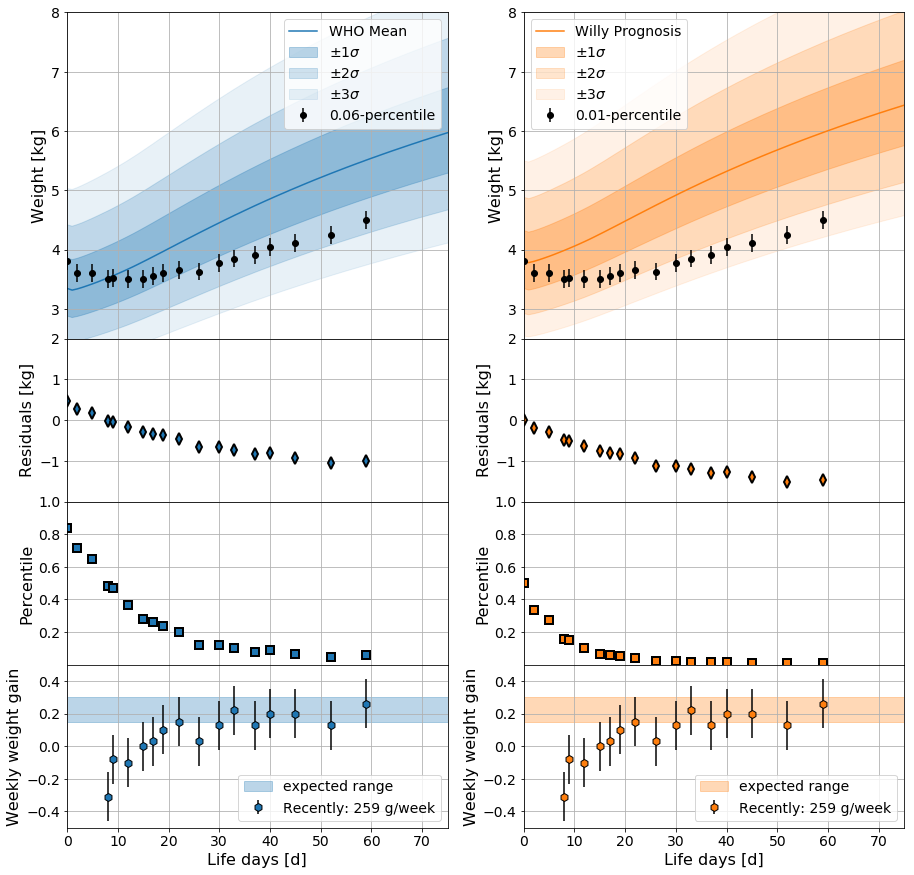

In [14]:
# ~~~~ Plot weight curve with more information ~~~~

fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0)

# Constant error assumed depending on experiences with baby scale
WEIGHT_ERROR = 0.15

# Find life_days where Willys weight was measured
willy_days = [willy_data['life_days']
              [i].days for i in range(len(willy_data['life_days']))]

# ~~~ Do subplot2grid subplotting to make lower plots look tighter ~~~

# Allocate axes array
axs = [[0, 0], [0, 0], [0, 0], [0, 0]]

# ~~ Plot comparison to WHO data ~~
# Plot weight data as above
axs[0][0] = plt.subplot2grid((5, 2), (0, 0), rowspan=2)
axs[0][0].plot(weight_data.Day, weight_data.SD0, color='C0')
axs[0][0].fill_between(weight_data.Day, weight_data.SD1neg,
                       weight_data.SD1, color='C0', alpha=0.3)
axs[0][0].fill_between(weight_data.Day, weight_data.SD2neg,
                       weight_data.SD2, color='C0', alpha=0.2)
axs[0][0].fill_between(weight_data.Day, weight_data.SD3neg,
                       weight_data.SD3, color='C0', alpha=0.1)

# Add Willy data
axs[0][0].errorbar(willy_days,
                   willy_data['measured_weight'],
                   color='black', linestyle='none', marker='o', yerr=WEIGHT_ERROR)

# Calculate Willys percentile
percentile = sc.norm.cdf(
    willy_data.iloc[-1]['measured_weight'], loc, scale)

# Legend, formatting, ...
axs[0][0].legend(['WHO Mean',
                  r'$\pm 1\sigma$',
                  r'$\pm 2\sigma$',
                  r'$\pm 3\sigma$', '%.2f-percentile' % percentile])
axs[0][0].set_ylim(2.5, YLIM)
axs[0][0].set_ylabel('Weight [kg]')
axs[0][0].grid()

# Plot residuals (difference Willys weight to prognosis)
axs[1][0] = plt.subplot2grid((5, 2), (2, 0), sharex=axs[0][0])
axs[1][0].plot(willy_days, willy_data['measured_weight'] -
               [weight_data['SD0'][i] for i in willy_days],
               'd', color='black', markersize=8, mfc='C0', mew=2)
axs[1][0].set_ylim(-2, 2)
axs[1][0].set_ylabel('Residuals [kg]')
axs[1][0].grid()

# Plot percentiles
axs[2][0] = plt.subplot2grid((5, 2), (3, 0), sharex=axs[0][0])
axs[2][0].plot(willy_days, sc.norm.cdf(willy_data['measured_weight'],
                                       [weight_data['SD0'][i]
                                           for i in willy_days],
                                       [weight_data['SD0'][i] - weight_data['SD1neg'][i] for i in willy_days]),
               's', color='black', markersize=8, mfc='C0', mew=2)

axs[2][0].set_ylim(0, 1)
axs[2][0].grid()
axs[2][0].set_ylabel('Percentile')

# Plot weekly weight gain
axs[3][0] = plt.subplot2grid((5, 2), (4, 0), sharex=axs[0][0])
axs[3][0].axhspan(0.15, 0.3, 0, willy_days[-1], alpha=0.3, color='C0')
axs[3][0].errorbar(willy_days,
                   willy_data['weekly_weight_gain'],
                   color='black', linestyle='none', marker='h', markersize=8, mfc='C0',
                   yerr=WEIGHT_ERROR)
axs[3][0].legend(['expected range',
                  r'Recently: %d g/week' % (willy_data.iloc[-1]['weekly_weight_gain']*1000)], loc=4)

axs[3][0].set_xlim(0, XLIM)
axs[3][0].set_ylim(-0.5, 0.5)
axs[3][0].grid()
axs[3][0].set_xlabel('Life days [d]')
axs[3][0].set_ylabel('Weekly weight gain')


# ~~ Plot comparison to Willys prognosis data ~~
# Plot weight data as above
axs[0][1] = plt.subplot2grid((5, 2), (0, 1), rowspan=2)
axs[0][1].plot(weight_data.Day, weight_data.SD0 + willy_diff2mean, color='C1')
axs[0][1].fill_between(weight_data.Day,
                       weight_data.SD1neg + willy_diff2mean,
                       weight_data.SD1 + willy_diff2mean,
                       color='C1', alpha=0.3)
axs[0][1].fill_between(weight_data.Day,
                       weight_data.SD2neg + willy_diff2mean,
                       weight_data.SD2 + willy_diff2mean,
                       color='C1', alpha=0.2)
axs[0][1].fill_between(weight_data.Day,
                       weight_data.SD3neg + willy_diff2mean,
                       weight_data.SD3 + willy_diff2mean,
                       color='C1', alpha=0.1)

# Add Willy data
axs[0][1].errorbar(willy_days,
                   willy_data['measured_weight'],
                   color='black', linestyle='none', marker='o', yerr=WEIGHT_ERROR)

# Calculate Willys percentile
percentile = sc.norm.cdf(willy_data.iloc[-1]['measured_weight'],
                         loc + willy_diff2mean,
                         scale)

# Legend, formatting, ...
axs[0][1].legend(['Willy Prognosis',
                  r'$\pm 1\sigma$',
                  r'$\pm 2\sigma$',
                  r'$\pm 3\sigma$', '%.2f-percentile' % percentile])
axs[0][1].set_ylim(2.5, YLIM)
axs[0][1].set_ylabel('Weight [kg]')
axs[0][1].grid()

# Plot residuals (difference Willys weight to prognosis)
axs[1][1] = plt.subplot2grid((5, 2), (2, 1), sharex=axs[0][1])
axs[1][1].plot(willy_days, willy_data['measured_weight'] - [weight_data['SD0'][i] + willy_diff2mean for i in willy_days],
               color='black', marker='d', linestyle='none', markersize=8, mfc='C1', mew=2)

axs[1][1].set_ylim(-2, 2)
axs[1][1].set_ylabel('Residuals [kg]')
axs[1][1].grid()

# Plot percentiles
axs[2][1] = plt.subplot2grid((5, 2), (3, 1), sharex=axs[0][1])
axs[2][1].plot(willy_days, sc.norm.cdf(willy_data['measured_weight'],
                                       [weight_data['SD0'][i] +
                                           willy_diff2mean for i in willy_days],
                                       [weight_data['SD0'][i] - weight_data['SD1neg'][i] for i in willy_days]),
               color='black', marker='s', linestyle='none', markersize=8, mfc='C1', mew=2)


axs[2][1].set_ylim(0, 1)
axs[2][1].grid()
axs[2][1].set_ylabel('Percentile')

# Plot weekly weight gain
axs[3][1] = plt.subplot2grid((5, 2), (4, 1), sharex=axs[0][1])
axs[3][1].axhspan(0.15, 0.3, 0, willy_days[-1], alpha=0.3, color='C1')
axs[3][1].errorbar(willy_days,
                   willy_data['weekly_weight_gain'],
                   color='black', linestyle='none', marker='h', markersize=8, mfc='C1',
                   yerr=WEIGHT_ERROR)
axs[3][1].legend(['expected range',
                  r'Recently: %d g/week' % (willy_data.iloc[-1]['weekly_weight_gain']*1000)], loc=4)

axs[3][1].set_xlim(0, XLIM)
axs[3][1].set_ylim(-0.5, 0.5)
axs[3][1].grid()
axs[3][1].set_xlabel('Life days [d]')
axs[3][1].set_ylabel('Weekly weight gain')

for ax in [axs[0][0], axs[1][0], axs[0][1], axs[1][1], axs[2][0], axs[2][1]]:
    plt.setp(ax.get_xticklabels(), visible=False)
    # The y-ticks will overlap with "hspace=0", so we'll hide the bottom tick
    ax.set_yticks(ax.get_yticks()[1:])

# Save it
#plt.savefig('180821_Willy_Weight.png')
plt.show()